<a href="https://colab.research.google.com/github/jbinteam/010723305/blob/main/Homework7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from PIL import Image
from scipy.ndimage import filters
import matplotlib.pyplot as plt
import cv2
from skimage import io
from skimage.util import img_as_ubyte
from google.colab.patches import cv2_imshow

<h1 style="text-align: center"> Harris Corner Detector SciPy Implement</h1>

$$ H_I = \nabla I \ \nabla I^T = \left[ \begin{matrix} I_x \\ I_y\end{matrix}\right]
                               \left[ \begin{matrix} I_x && I_y\end{matrix}\right] 
                            =  \left[ \begin{matrix} I_x^2 && I_xI_y \\
                                                     I_xI_y && I_Y^2 \end{matrix}\right]$$

$$ \overline{H}_I = W * H_I$$

$$ R=det\left( \overline{H}_I\right) - k\ trace \left( \overline{H}_I\right)^2 $$

$$ to\ get\ rid\ of\ weighting\ k\  : \frac{det\left( \overline{H}_I\right)}{trace \left( \overline{H}_I\right)+ \epsilon} $$

In [2]:
def compute_harris_response(im, sigma=3) : 
    
    # Gaussian derivative
    Ix = np.zeros(im.shape)
    filters.gaussian_filter(im, (sigma, sigma), (0,1), Ix)
    Iy = np.zeros(im.shape)
    filters.gaussian_filter(im, (sigma, sigma), (1,0), Iy)
    
    fig, axes = plt.subplots(1, 2, figsize=(10,10))
    for ax in axes :
        ax.axis('off')
    axes[0].imshow(Ix, cmap = 'gray')
    axes[1].imshow(Iy, cmap = 'gray')
    
    # Compute components of the Harris matrix
    Sxx = filters.gaussian_filter(Ix*Ix, sigma)
    Sxy = filters.gaussian_filter(Ix*Iy, sigma)
    Syy = filters.gaussian_filter(Iy*Iy, sigma)

    # Determinant and Trace
    Hdet  = Sxx*Syy - Sxy**2
    Htr = Sxx + Syy
    
    # Response function
    R = Hdet - 0.04*Htr**2

    fig, axes = plt.subplots(1,2, figsize=(10,10))
    for ax in axes : 
        ax.axis('off')

    axes[0].imshow(im, cmap= 'gray' )
    axes[1].imshow(R, cmap='jet')

    return R

In [3]:
def get_harris_points(harrisim, min_dist=10, threshold = 0.1) :
    
    # find top corner candidates above a threshold
    harrisim *= (1.0/harrisim.max()) # normalization
    corner_threshold = harrisim.max() * threshold
    harrisim_t = (harrisim > corner_threshold) * 1

    fig, axes = plt.subplots(1, 2, figsize=(10,10))
    for ax in axes :
        ax.axis('off')
    axes[0].imshow(harrisim, cmap='jet')
    axes[1].imshow(harrisim_t, cmap = 'gray')

    # get coordinates of candidates
    coords = np.array(harrisim_t.nonzero()).T

    # get candidates values
    candidates_values = [harrisim[c[0], c[1]] for c in coords]

    # sort candidates
    index = np.argsort(candidates_values)

    # store allowed point locations in array
    allowed_locations = np.zeros(harrisim.shape)
    allowed_locations[min_dist: -min_dist, min_dist: -min_dist] = 1
    

    # select the best points taking min_distance into account
    filtered_coords = list()
    for i in index :
        if allowed_locations[coords[i, 0], coords[i, 1]] == 1 :
            filtered_coords.append(coords[i])
            allowed_locations[(coords[i, 0] - min_dist): (coords[i, 0] + min_dist), (coords[i, 1] - min_dist): (coords[i, 1] + min_dist)] = 0
    
    return filtered_coords

In [4]:
def plot_harris_points(image, filtered_coords) :

    fig, axes = plt.subplots(1, 2, figsize=(10,10), subplot_kw={'aspect': 1})
    
    axes[0].set_xlim([0, image.shape[1]])
    axes[0].set_ylim([-image.shape[0],0] )
    axes[0].plot([p[1] for p in filtered_coords], [-p[0] for p in filtered_coords], 'r*')
    axes[1].axis('off')
    axes[1].imshow(image)
    axes[1].plot([p[1] for p in filtered_coords], [p[0] for p in filtered_coords], 'r*')

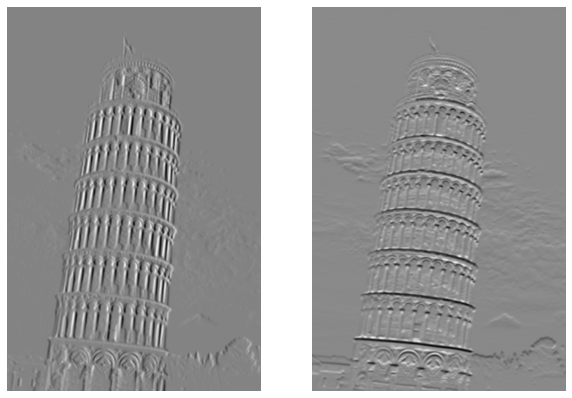

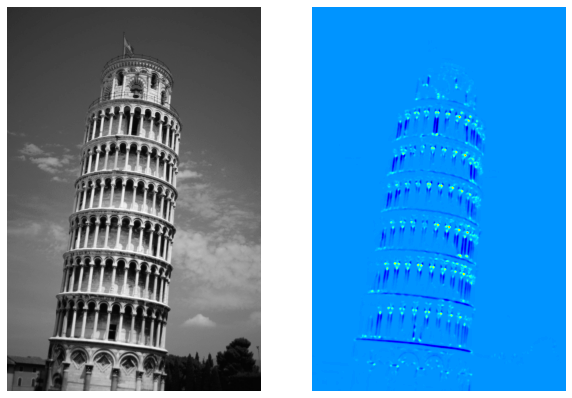

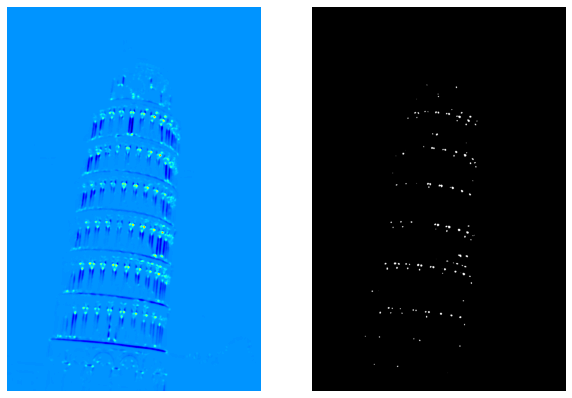

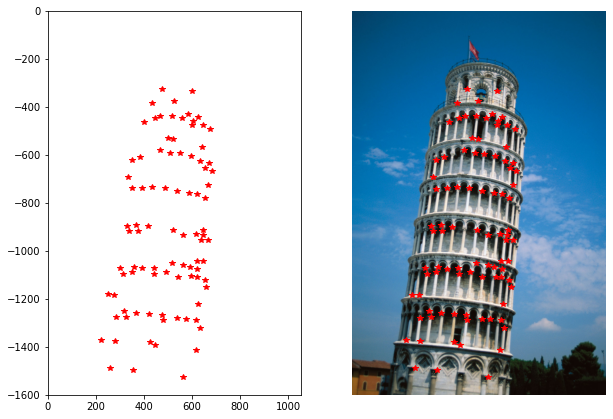

In [5]:
im_url = "https://github.com/jbinteam/010723305/blob/main/images/Leaning-Tower-of-Pisa-Italy.jpg?raw=true"
im = io.imread(im_url)
im_gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)

harrisim = compute_harris_response(im_gray, sigma=3)
filtered_coords = get_harris_points(harrisim, min_dist=20, threshold = 0.2)
plot_harris_points(im, filtered_coords)

<h1 style="text-align: center;"> Harris Corner Detector OpenCV</h1>

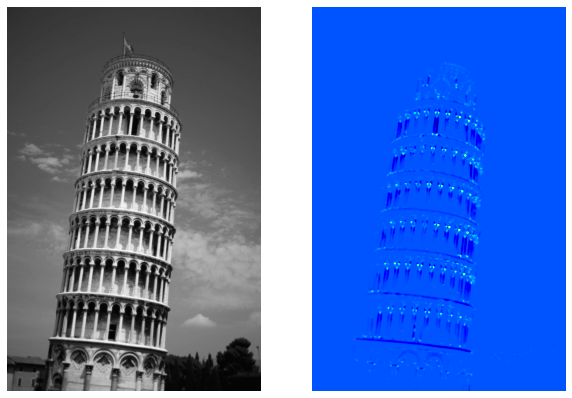

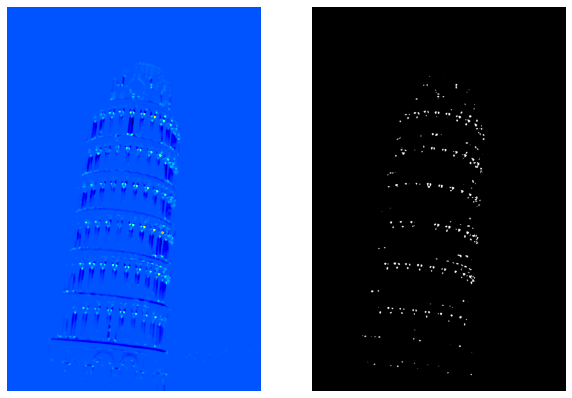

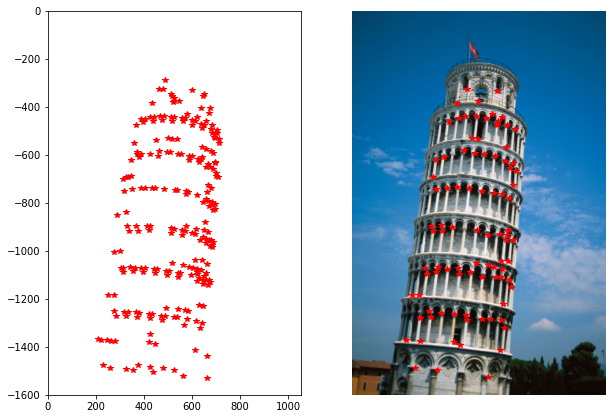

In [6]:
im_url = "https://github.com/jbinteam/010723305/blob/main/images/Leaning-Tower-of-Pisa-Italy.jpg?raw=true"
im = io.imread(im_url)
im_gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)

im_gray = np.float32(im_gray)

R = cv2.cornerHarris(im_gray,9,21,0.05)

fig, axes = plt.subplots(1,2, figsize = (10,10))
for ax in axes :
    ax.axis('off')
axes[0].imshow(im_gray, cmap = 'gray')
axes[1].imshow(R, cmap = 'jet')

#normalization
R_normed = np.zeros(R.shape, dtype=np.float32)
cv2.normalize(R,R_normed, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

#thresholding
corner = np.where(R_normed > 70)
R_threshold = np.zeros(R.shape)
R_threshold[corner] = 255


fig, axes = plt.subplots(1,2, figsize = (10,10))
for ax in axes :
    ax.axis('off')
axes[0].imshow(R_normed, cmap = 'jet')
axes[1].imshow(R_threshold, cmap = 'gray')

#detecting reponse contours
contours, _hierachy = cv2.findContours(np.uint8(R_threshold), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#list of corners location
coords = list()

for contour in contours :
    moment = cv2.moments(contour)
    if moment['m00'] > 0 :
        cX = int(moment['m10'] / moment['m00'])
        cY = int(moment['m01'] / moment['m00'])
        coords.append((cX,cY))

fig, axes = plt.subplots(1, 2, figsize=(10,10), subplot_kw={'aspect': 1})

axes[0].set_xlim([0, im.shape[1]])
axes[0].set_ylim([-im.shape[0],0] )
axes[0].plot([p[0] for p in coords], [-p[1] for p in coords], 'r*')
axes[1].axis('off')
axes[1].imshow(im)
axes[1].plot([p[1] for p in filtered_coords], [p[0] for p in filtered_coords], 'r*')

<h1 style = "text-align: center"> Corner Detector With Noble Response Function</h1>

<h2>แบบฝึกหัดที่ 7.1</h2>
<h4>วัตถุประสงค์ </h1>

- ทักษะการแปลงสมการทางคณิตศาสตร์เป็น code
<h4>โจทย์</h4>

- ให้นักศึกษาแปลง code ในตัวอย่างที่ 1 ให้เป็น Corner Detector ที่ใช้ Noble Response Function (สไลด์หน้าที่ 57)

In [7]:
## coding here ##

<h1 style = "text-align: center"> Shi-Tomasi corner detector (Mineigenvalues)</h1>

<h2>แบบฝึกหัดที่ 7.2</h2>
<h4>วัตถุประสงค์ </h1>

- ทดลองใช้งานและเปรียบเทียบผลของ Response Function ของ Corner detector
<h4>โจทย์</h4>

- ให้นักศึกษาเขียน code เพื่อใช้งาน Shi-Tomasi Corner detector ภายใน opencv
<a href="https://docs.opencv.org/4.5.3/dd/d1a/group__imgproc__feature.html#ga3dbce297c1feb859ee36707e1003e0a8">cornerMinEigenVal()</a>

- เปรียบเทียบ Response ที่ได้จาก Shi-Tomasi corner detector กับ Harris corner detector โดยใช้ค่า Threshold เดียวกัน Corner Detector ตัวไหนให้จำนวนมุมที่ตรวจจับได้มากกว่า เพราะเหตุใด และคิดว่าเป็นผลดีสำหรับการนำไปใช้งานต่อหรือไม่

In [8]:
## coding here ##